# Homework 5 - Bayesian Networks

**Name**: Nima Behrang

**Student Number**: 96100114

**Sources**: My brain, notes and computer

### Install & import the required packages
You are to implement the algorithms yourself and forbided from the use of dedicated packages!

In [48]:
!pip install numpy tqdm scipy seaborn matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import random
import scipy as sp
from scipy.stats import norm
from tqdm import *
import seaborn as sns
import matplotlib.pyplot as plt

### Load input data
`input.txt` contains a sample log of vahid's location and `ground_truth.txt` holds the initial state and the hidden state's correrct location at each time-frame, employ it to validate your findings.

In [8]:
with open('input.txt', 'r') as file:
    n, k, mean_pace, t = file.readline().split(' ')
    n, t, k, mean_pace = int(n), int(t), float(k), float(mean_pace)
    sen_error_mean, sen_error_std, sen_xs, sen_ys = list(), list(), list(), list()
    for i in range(n):
        x,y, mu, sig = map(float, file.readline().split(' '))
        sen_xs.append(x)
        sen_ys.append(y)
        sen_error_mean.append(mu)
        sen_error_std.append(sig)
    sen_error_mean = np.array(sen_error_mean)
    sen_error_std = np.array(sen_error_std)
    sens = np.stack([np.array(sen_xs), np.array(sen_ys)], axis=1)
    distances = [np.array(list(map(float, file.readline().split(' ')))) for i in range(t)]
with open('ground_truth.txt', 'r') as file:
    ground_truth = [np.array(list(map(float, line.split(' ')))) for line in  file.readlines()]

### Implement utility functions
Implement the utility functions required for particle filtering (the following strucutre is merely a suggestion and you can choose to discard it).

In [22]:
np.minimum([2, 3, 4, 5], 3)

array([2, 3, 3, 3])

In [9]:
def move(particles: np.array, mean_pace: float, reverse=False):
    get_dir = lambda: np.array([2*np.random.randint(2)-1, 2*np.random.randint(2)-1]) * np.random.exponential(mean_pace)
    return [p + get_dir() for p in particles]

In [23]:
def distance(particles: np.array, sensors: np.array):
    return np.maximum(np.minimum([[np.linalg.norm(p-s) for p in particles] for s in sensors], 200), 0)

In [24]:
def weights(distances:np.array, gt_distances:np.array, sen_err_means:np.array, sen_err_stds:np.array):
    ps = []
    res = []
    norms = [norm(mu, std) for mu, std in zip(sen_err_means, sen_err_stds)]
    for n, dist, d in zip(norms, gt_distances, distances):
        ps.append(n.pdf(dist - d))
    ps = np.array(ps).transpose()
    for p in ps:
        res.append(np.prod(p))
    return res
#     return np.array([np.prod([[n.pdf()] for d, p, n in zip(distances, p_distances, norms)]) for diff in diffs])

In [25]:
def resample(liklihood:np.array, particles:np.array):
    return random.choices(particles, weights=liklihood/sum(liklihood), k=len(liklihood))

## A. Particle Filtering

In [88]:
top_loc = []
all_loc = []
SAMPLES = 5000
ws = np.ones(SAMPLES)
particles = np.array([[np.random.randint(201), np.random.randint(201)] for _ in range(SAMPLES)])
pace = mean_pace
for d in tqdm(distances):
    particles = move(particles, pace)
    distances_p = distance(particles, sens)
    ws = weights(d, distances_p, sen_error_mean, sen_error_std)
    top_loc.append(particles[np.argmax(ws)])
    all_loc = all_loc + particles
    particles = resample(ws, particles)
    pace *= k
top_loc = np.array(top_loc)
all_loc = np.array(all_loc)

100%|██████████| 52/52 [00:18<00:00,  2.78it/s]


In [27]:
tops = np.argsort(ws)[-3:]
print(particles[tops[0]], particles[tops[1]], particles[tops[2]])
print('ground truth', *ground_truth[-1])

[129.76821201 126.6968773 ] [128.58783259 127.80492943] [129.22908551 127.11155924]
ground truth 131.62252381461028 123.0757221368539


Elaborate on why your findings vary from the ground truth? (if they do)

## B. Plot your trajectory prediction

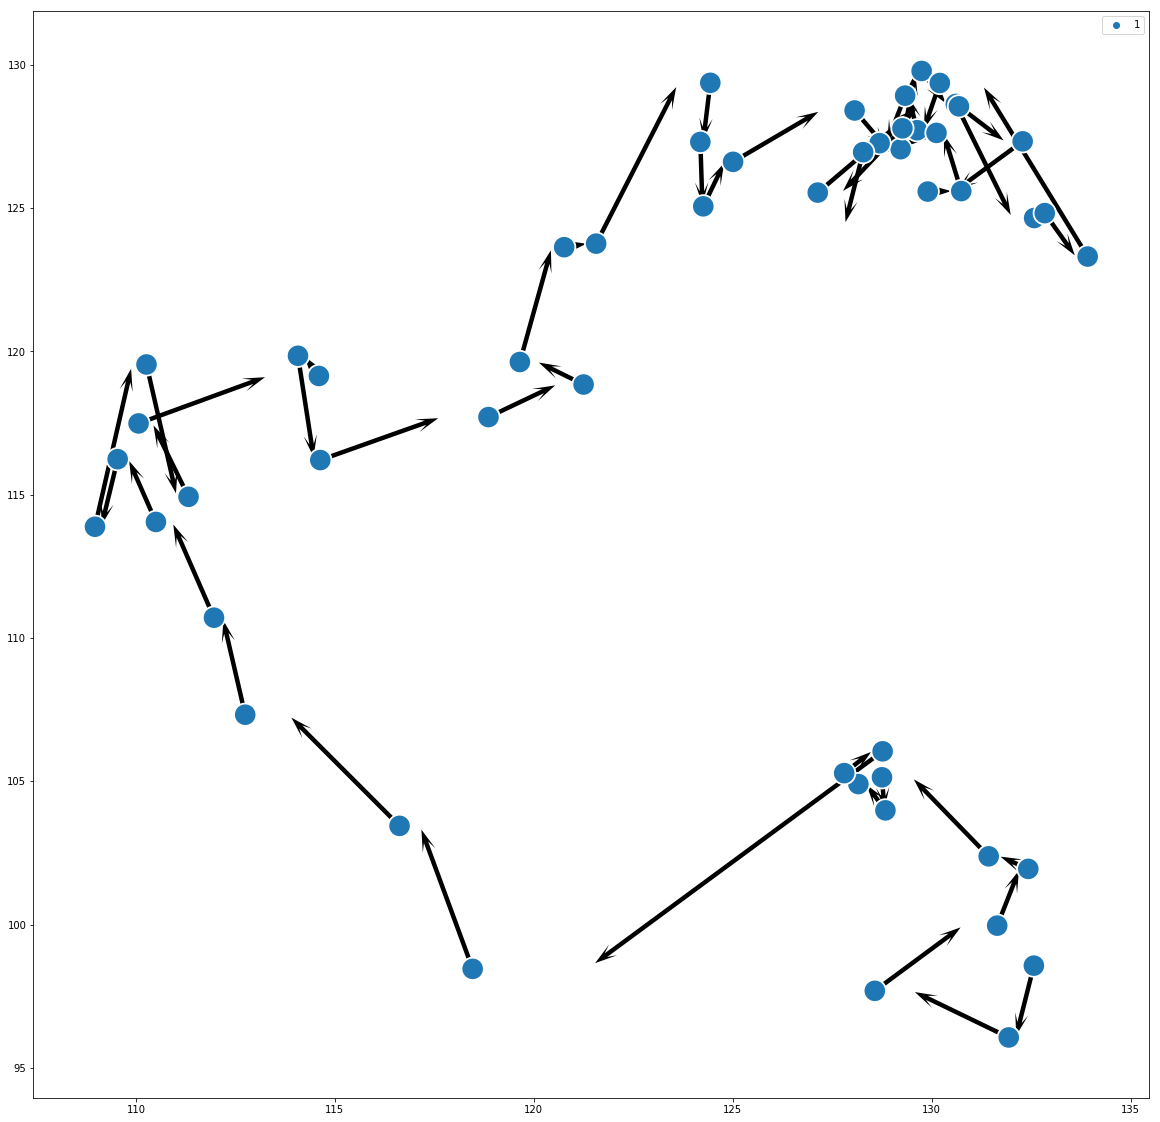

In [87]:
plt.figure(figsize=(20, 20))
diff = top_loc[1:] - top_loc[:-1]
# for i in range(len(top_loc) - 1):
#     plt.arrow(*top_loc[i], *top_loc[i+1])
plt.quiver(top_loc[:,0], top_loc[:,1], diff[:, 0], diff[:,1], linewidths=1, headaxislength=3, scale=40, width=0.004)
sns.scatterplot(x=top_loc[:,0], y=top_loc[:,1], s=500, hue=1)

Provide a short analysis of your resulting graph.

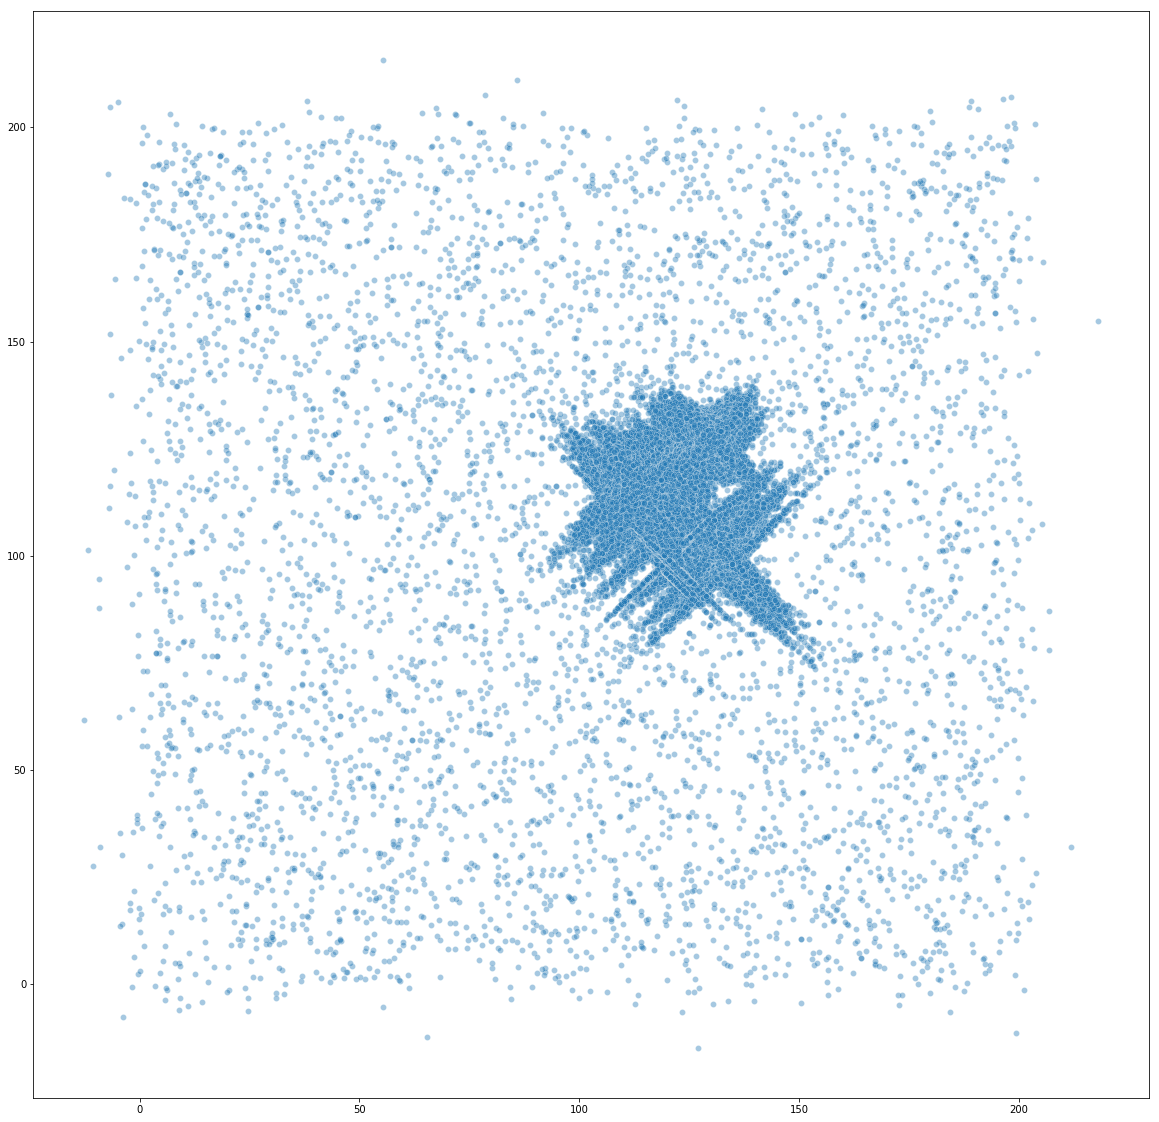

In [98]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=all_loc[:, 0], y=all_loc[:, 1], alpha=0.4)

## C. Predict the trajectory's initial point

In [29]:
init = ground_truth[-1]
SAMPLES = 5000
ws = np.ones(SAMPLES)
particles = np.array([init for _ in range(SAMPLES)])
pace_r = pace
for d in tqdm(reversed(distances), total=len(distances)):
    particles = move(particles, pace_r)
    distances_p = distance(particles, sens)
    ws = weights(d, distances_p, sen_error_mean, sen_error_std)
    particles = resample(ws, particles)
    pace_r /= k

52it [00:18,  2.74it/s]


In [30]:
tops = np.argsort(ws)[-3:]
print(particles[tops[0]], particles[tops[1]], particles[tops[2]])
print('ground truth', *ground_truth[0])

[131.84762199  94.95326053] [133.07358068  96.96239417] [132.74264203  95.03365933]
ground truth 135.83679679202822 97.44314501991664


## D. 
Elaborate on whether this process is always a possibility for HMMs?

<div dir="rtl">
خیر، در صورتی که توابع گذر از استیت به استیت بعد معکوس پذیر باشد، ممکن است و اگر معکوس پذیر نبوده یا پیچیدگی محاسباتی بالا داشته باشد، ممکن نیست.
</div>

## E. Analysis of different k values
Briefly explain what values of $k$ would eventually lead to better predictions?

<div dir="rtl">
به ازای مقادیر کوچکتر از یک چون به مرور مکان فرد به محل مشخصی میل می کند، مسئله خوب حل می شود و ذرات به مقدار مشخصی همگرا می شوند اما اگر از ۱ بیشتر باشد عملا در هر مرحله، یک جهش تصادفی با گام بلندتر به محلی تصادفی می کند.
</div>